In [1]:
# Importing the relevant packages
import io
import itertools

import numpy as np
import sklearn.metrics

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Downloading and preprocessing the data

In [2]:
# Defining some constants/hyperparameters
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [3]:
# Downloading the MNIST dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [4]:
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [5]:
# Creating a function to scale our data
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [6]:
# Scaling the data
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [7]:
# Defining the size of validation set
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [8]:
# Defining size of test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [9]:
# Reshuffling the dataset
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [10]:
# Splitting the dataset into training + validation
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [11]:
# Batching the data
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

In [12]:
# Extracting the numpy arrays from the validation data for the calculation of the Confusion Matrix
for images, labels in validation_data:
    images_val = images.numpy()
    labels_val = labels.numpy()

## Creating the model and training it

In [13]:
# Now that we have preprocessed the dataset, we can define our CNN and train it

In [14]:
# Outlining the model/architecture of our CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

In [15]:
# A brief summary of the model and parameters
model.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 12, 12, 50)            0           
                                                                           
 conv2d_1 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten (Flatten)               (None, 1250)                  0           
                                                                           
 dense (Dense)                   (None, 10)                    12510

In [16]:
# Defining the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [17]:
# Compiling the model with Adam optimizer and the cathegorical crossentropy as a loss function
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [18]:
log_dir = "Logs\\fit\\" + "run-1"

In [19]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    # The next three lines arrange x and y labels given the class names
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [20]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [21]:
# Define a file writer variable for logging purposes
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(images_val)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
    
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [22]:
# Defining the callbacks
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

In [23]:
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [24]:
# Train the network
model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [tensorboard_callback, cm_callback, early_stopping], 
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20
188/188 [==============================] - 1s 6ms/step
422/422 - 29s - loss: 0.2610 - accuracy: 0.9276 - val_loss: 0.0827 - val_accuracy: 0.9738 - 29s/epoch - 70ms/step
Epoch 2/20
188/188 [==============================] - 1s 6ms/step
422/422 - 29s - loss: 0.0711 - accuracy: 0.9784 - val_loss: 0.0684 - val_accuracy: 0.9793 - 29s/epoch - 68ms/step
Epoch 3/20
188/188 [==============================] - 1s 5ms/step
422/422 - 32s - loss: 0.0523 - accuracy: 0.9847 - val_loss: 0.0436 - val_accuracy: 0.9868 - 32s/epoch - 77ms/step
Epoch 4/20
188/188 [==============================] - 1s 5ms/step
422/422 - 29s - loss: 0.0431 - accuracy: 0.9864 - val_loss: 0.0325 - val_accuracy: 0.9897 - 29s/epoch - 69ms/step
Epoch 5/20
188/188 [==============================] - 2s 8ms/step
422/422 - 30s - loss: 0.0363 - accuracy: 0.9890 - val_loss: 0.0254 - val_accuracy: 0.9932 - 30s/epoch - 72ms/step
Epoch 6/20
188/188 [==============================] - 1s 6ms/step
422/422 - 31s - loss: 0.0307 - acc

## Testing our model

In [25]:
# Testing our model
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 3s 3s/step - loss: 0.0284 - accuracy: 0.9917


In [26]:
# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0284. Test accuracy: 99.17%


## Visualizing in Tensorboard

In [28]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "logs/fit"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


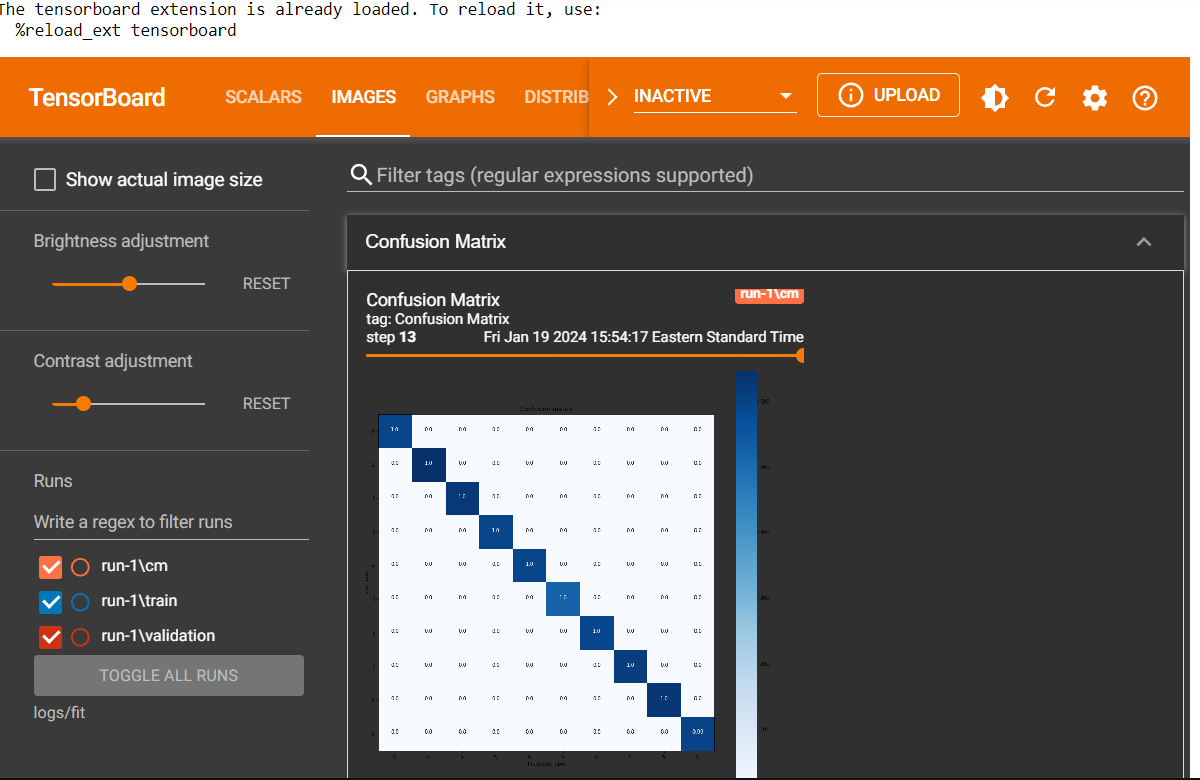